### <center>Student: *Chernyshev Daniil*</center>

## Description

1. Choose the time period to form the graph
2. Those how are making projects on artilces: half of you need to choose co-authorship graph, others - citation (but consider citation graph as undirected for simplicity)
3. Use weighted graph so that probabilities of infection passing is proportional to the edge weight 

### Data

In [1]:
import pandas as pd
from collections import Counter
import networkx as nx

In [2]:
xl_file = r'.\data.csv'
data=pd.read_csv(xl_file,sep=';')['Author']

In [3]:
res={}
for i in data:
    aus=i.split(';')
    auids=[l.split(':')[1] for l in aus]
    for j in auids:
        c=Counter([k for k in auids if k!=j])
        if j in res:
            res[j]+=c
        else:
            res[j]=c

In [4]:
edges=[]
for k, v in res.items():
    for j, w in v.items():
        edges.append((k, j, w))

In [5]:
T=nx.Graph()
T.add_weighted_edges_from(edges)
X=nx.convert_node_labels_to_integers(T)

### Sampling

In [6]:
import random
import matplotlib.pyplot as plt
import time

In [7]:
def forestfire(G,size):
        T=nx.Graph()
        list_nodes=set(G.nodes())
        d = set()
        random_node = random.sample(list_nodes,1)[0]
        q = set() 
        q.add(random_node)
        while(len(T.nodes())<size):
            print(len(list_nodes),len(T.nodes()), len(q))
            if(len(q)>0):
                initial_node = q.pop()
                list_nodes.remove(initial_node)
                if(initial_node not in d):
                    d.add(initial_node)
                    print()
                    neighbours = list(G.neighbors(initial_node))
                    np = random.randint(1,len(neighbours))
                    for x in neighbours[:np]:
                        if(len(T.nodes())<size):
                            T.add_edge(initial_node,x)
                            q.add(x)
                        else:
                            break
                else:
                    continue
            else:
                if len(set(list_nodes) and d)>0:
                    random_node = random.sample(set(list_nodes) and d,1)[0]
                    print(random_node)
                else:
                    random_node = random.sample(list_nodes,1)[0]
                q.add(random_node)
        q.clear()
        return T

Unfortunately, python ODE libriaries are unable to compute large graphs (more than 300 cliques or 2k nodes) in reasonable time(it can take 25-60 minutes depending on graph configuration) so the only legitimate choice is to resort to graph sampling algorithms. According to https://cs.stanford.edu/~jure/pubs/sampling-kdd06.pdf Forest Fire is a good candidate however it cannot deal with unconnected graphs. Firstly lets take largest component of our graph.

In [8]:
G=nx.convert_node_labels_to_integers(max(nx.connected_component_subgraphs(X), key=len))

### Model

Consider SIR-based epidemic model using idea of percolation

Link to source: http://www.leonidzhukov.net/hse/2015/networks/papers/networks-book-ch21.pdf 

### Task

You are in charge of leading the vaccination campaign against some outbroken nonlethal disease. You have options to vactinate or provide medical treatment to infected ones. However, everything has its costs:
* Vaccination of a node costs $500 \$$ and make it immune to the disease all life-long. Unfortunately, you can help this way only to no more than $10\%$ of your nodes
* Medical Treatment costs $120\$$ per day of illness period, which in turn may take from $3$ to $7$ days

Your task is to implement the simulation model, propose some vaccination strategies and compare them (one iteration = one day).

In [9]:
import numpy as np
import scipy as sp
from numpy.linalg import eig
from scipy.integrate import odeint
from numba import jit

## Graph generator in case if we are not satisfied with our graph

In [10]:
#from GraphGenerator import *
#G=generateBase(300)
#n=len(G.nodes())
#generateBridges(G, n)

## Simulation

In [11]:
sd=1021
rd=np.random.RandomState(sd)

In [12]:

# System of differential equations..

@jit
def sir(z, t, A, n, gamma, days_to_recover=4):
    gamma+=np.fix(z[n:2*n])
    tp=0.3
    beta=1/np.max(A)
    return np.concatenate((
        -beta * z[0:n] * A.dot(z[n:2*n]),
         beta * z[0:n] * A.dot(z[n:2*n]) - np.clip(1/days_to_recover*gamma, 0, 1) * z[n:2*n],
         np.clip(1/days_to_recover*gamma, 0, 1) * z[n:2*n]
        ))

In [13]:
def simulate(G, time=50,percentage_of_patients_zero=0.01, candidates=[]):
    A = np.array(nx.adj_matrix(G).todense())
    n=len(G.nodes())

    # Time domain
    t = np.arange(0,time,1)

    # Initial state
    idx = rd.choice(range(n), int(np.ceil(n*percentage_of_patients_zero)))
    i0 = np.zeros((n,))
    i0[idx] = 1
    z0 = np.concatenate((1-i0,i0,np.zeros((n,))))
    if len(candidates)>0:
        ids=[i[0]+2*n for i in candidates]
        z0[ids]+=1
    gamma=np.full(n, -2.)
    np.random.seed(sd)
    return(odeint(sir, z0, t, (A, n, gamma)))

In [14]:
def drawResults(z, n, time=50, step=5):
    lim=min(n, time)
    s = np.sum(z[:,0:n], axis=1)[:lim]/n*100
    x = np.sum(z[:,n:2*n], axis=1)[:lim]/n*100
    r = np.sum(z[:,2*n:3*n], axis=1)[:lim]/n*100


    fig, ax = plt.subplots(1,1,figsize=(20,10))
    ax.plot(s,color = 'blue')
    ax.plot(x,color = 'red')
    ax.plot(r,color = 'green')
    ax.set_xlabel('$Day$')
    ax.set_ylabel('%')
    ax.set_xticks(np.arange(0,time+1,step))
    ax.set_xlim(right=time+1)
    ax.set_yticks(np.arange(0,101,5))
    ax.set_title('Percentage of Infected', fontsize = 15)

In [15]:
def drawCosts(z, n, time=50, step=5):
    lim=min(n, time)
    x = np.sum(z[:,n:2*n]*120, axis=1)[:lim]


    fig, ax = plt.subplots(1,1,figsize=(10,6))
    ax.plot(x,color = 'black')
    ax.set_xlabel('$Day$')
    ax.set_ylabel('$')
    ax.set_xticks(np.arange(0,time+1,step))
    ax.set_xlim(right=time+1)
    ax.set_title('Daily epidemic costs', fontsize = 15)

In [58]:
n=len(G.nodes())
z=simulate(G, time=100,percentage_of_patients_zero=0.001)
end=np.argmax(np.sum(z[:,2*n:3*n], axis=1))

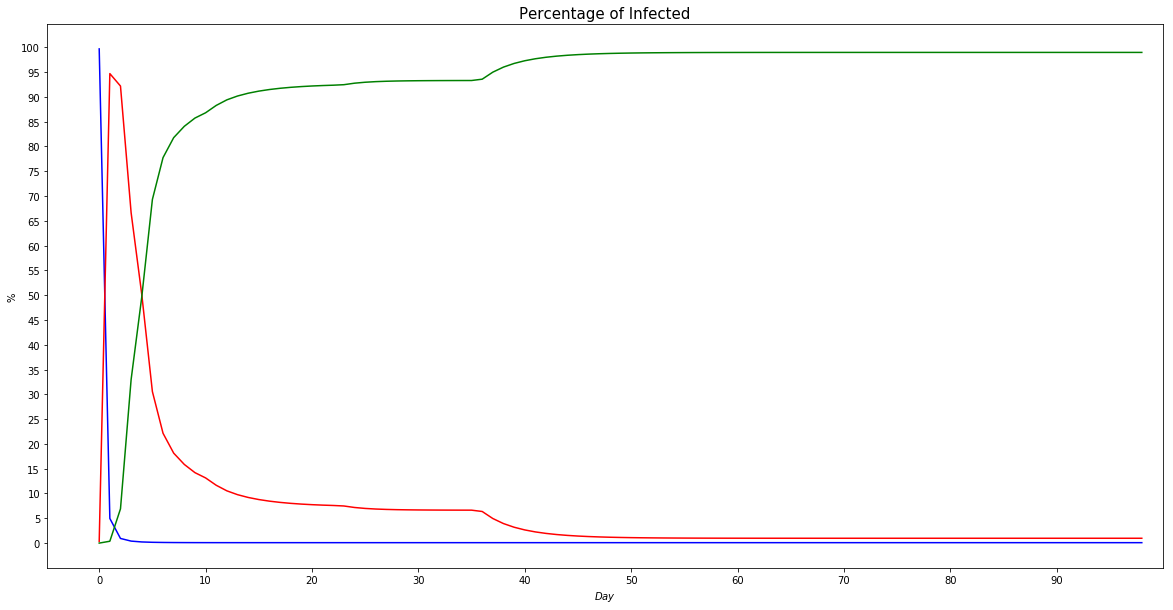

In [61]:
drawResults(z, n, time=end, step=10)

In [18]:
z_n=[['No Vaccination', np.sum(z[:,n:2*n]*120)]]

## Centrality strategy

Graph properties may be good candidates for vaccination starting points. Centralities may reflect most influencial (or viral nodes) which can be useful for isolating site of epidemic.

In [19]:
f=[nx.degree_centrality,nx.closeness_centrality,nx.information_centrality,nx.load_centrality,nx.harmonic_centrality]
l=['Degree', 'Closeness', 'Information','Load', 'Harmonic']

In [20]:
[0 for i in range(len(l))][0]

0

In [256]:
res=[0 for i in range(len(l))]
trials=10
for k in range(trials):
    comp=[]
    for i in range(len(f)):
        try:
            a=f[i](G, weight='weight')
        except:
            a=f[i](G)
        b=sorted(a.items(), key=lambda x: x[1], reverse=True)
        candidates=b[:int(n*0.1)]
        comp.append(simulate(G, time=100,percentage_of_patients_zero=0.001, candidates=candidates))
    for i in range(len(l)):
        res[i]+=np.sum(comp[i][0][2*n:3*n])*500+np.sum(comp[i][:,n:2*n]*120)


In [257]:
ar=z_n+[[l[i],res[i]/trials] for i in range(len(l))]

In [258]:
df = pd.DataFrame(ar,columns = ['Centrality','Total Expenses']) 

In [259]:
df

,Centrality,Total Expenses
0,No Vaccination,255988.613209
1,Degree,280185.852966
2,Closeness,304843.407249
3,Information,317092.268966
4,Load,335629.558325
5,Harmonic,346087.672140


In [29]:
df

,Centrality,Total Expenses
0,No Vaccination,255988.613209
1,Degree,323057.278789
2,Closeness,312355.574962
3,Information,292297.098831
4,Load,320096.144434
5,Harmonic,329420.639281


Vaccinating before outbreak has unpredictable effect due to random nature of infection.

## Solving using vaccination coefficient

The most optimal strategy is to isolate epidemic sites at the beginning of infection. This is possible since vaccination is instant. To achieve this we have to calculate distances to infected nodes and prioritize treating the closest. If we are lucky and our vaccination limit is sufficient to build immunity walls we will end the outbreak in first iterations. If we are not, we have to face grim reality and try to isolate as many healthy nodes as possible. This problem is complex since finding optimal borders is computational heavy task, especially if network is a combination of cliques and bridges.

In [250]:

# System of differential equations..
dist=nx.floyd_warshall_numpy(G)
dist=dist/np.max(dist)
@jit
def sirMOD(z, t, A, n, gamma, days_to_recover=4):
    gamma+=np.fix(z[n:2*n])
    tmp=dist*np.diag(np.round(z[n:2*n]))
    vac=(np.ones(n)-np.min(np.where(tmp==0, 1, tmp), axis=0).T)
    
    print(vac)
    tp=0.3
    beta=1/np.max(A)
    return np.concatenate((
        -beta * z[0:n] * A.dot(z[n:2*n])-vac*z[0:n],
         beta * z[0:n] * A.dot(z[n:2*n]) - np.clip(1/days_to_recover*gamma, 0, 1) * z[n:2*n],
         np.clip(1/days_to_recover*gamma, 0, 1) * z[n:2*n]+vac*z[3*n:4*n],
         vac*z[0:n]-vac*z[3*n:4*n],
        ))

In [251]:
def simulateMod(G, time=50,percentage_of_patients_zero=0.01):
    A = np.array(nx.adj_matrix(G).todense())
    n=len(G.nodes())
    
    # Time domain
    t = np.arange(0,time,1)

    # Initial state
    idx = rd.choice(range(n), int(np.ceil(n*percentage_of_patients_zero)))
    i0 = np.zeros((n,))
    i0[idx] = 1
    z0 = np.concatenate((1-i0,i0,np.zeros((n,)),np.zeros((n,))))
    gamma=np.full(n, -2.)
    np.random.seed(sd)
    return(odeint(sirMOD, z0, t, (A, n, gamma)))

In [252]:
tps=simulateMod(G)

[0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.8 0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.8 0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.8 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. 

[0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.8 0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.8 0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.8 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. 

[0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.8 0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.8 0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.8 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. 

[0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.8 0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.8 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.8 0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.8 0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.8 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. 

[0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.8 0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.8 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.8 0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.8 0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.8 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. 

[0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8
 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8
 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8
 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8
 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.  0.8 0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.8 0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.8 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.8 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. 

[0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8
 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8
 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8
 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8
 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.  0.8 0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.8 0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.8 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.8 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. 

[0.  0.8 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.8 0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.8 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.8
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.8 0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.8 0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.8 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.

[0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8
 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8
 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8
 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8
 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.  0.8 0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.8 0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.8 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.8 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. 

[0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8
 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8
 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8
 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8
 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.  0.8 0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.8 0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.8 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.8 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. 

[0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8
 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8
 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8
 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8
 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.  0.8 0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.8 0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.8 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.8 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. 

[0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8
 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8
 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8
 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8
 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.8 0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.8 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.8 0.  0.  0.  0.  0.8 0.  0.
 0.  0.  0.8 0.  0.  0.  0.  0.8 0.  0.  0.  0.  0.8 0.  0.  0.  0.  0.8
 0.  0.  0.  0.  0.8 0.  0.  0.  0.  0.8 0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.

[0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8
 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8
 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8
 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8
 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.  0.8 0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.8 0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.8 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.8 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.8
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.

[0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8
 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8
 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8
 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8
 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.  0.8 0.  0.  0.8 0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.8 0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.8 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.8 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.8
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.

[0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8
 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8
 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8
 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8
 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.8 0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.8 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.8 0.  0.  0.  0.  0.8 0.  0.
 0.  0.  0.8 0.  0.  0.  0.  0.8 0.  0.  0.  0.  0.8 0.  0.  0.  0.  0.8
 0.  0.  0.  0.  0.8 0.  0.  0.  0.  0.8 0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.

[0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8
 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8
 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8
 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8
 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.8 0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.8 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.8 0.  0.  0.  0.  0.8 0.  0.
 0.  0.  0.8 0.  0.  0.  0.  0.8 0.  0.  0.  0.  0.8 0.  0.  0.  0.  0.8
 0.  0.  0.  0.  0.8 0.  0.  0.  0.  0.8 0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.

[0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8
 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8
 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8
 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8
 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.8 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.8 0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.8 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.8 0.  0.  0.  0.  0.8 0.  0.
 0.  0.  0.8 0.  0.  0.  0.  0.8 0.  0.  0.  0.  0.8 0.  0.  0.  0.  0.8
 0.  0.  0.  0.  0.8 0.  0.  0.  0.  0.8 0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.

[0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8
 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8
 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8
 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8
 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8
 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.8 0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.8 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.8 0.  0.  0.  0.  0.8 0.  0.
 0.  0.  0.8 0.  0.  0.  0.  0.8 0.  0.  0.  0.  0.8 0.  0.  0.  0.  0.8
 0.  0.  0.  0.  0.8 0.  0.  0.  0.  0.8 0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0

[0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8
 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8
 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8
 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8
 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8
 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.  0.
 0.8 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.8 0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.8 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.8 0.  0.  0.  0.  0.8 0.  0.
 0.  0.  0.8 0.  0.  0.  0.  0.8 0.  0.  0.  0.  0.8 0.  0.  0.  0.  0.8
 0.  0.  0.  0.  0.8 0.  0.  0.  0.  0.8 0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0

[0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8
 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8
 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8
 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8
 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8
 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.  0.
 0.8 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.8 0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.8 0.8 0.8 0.8 0.8 0.8 0.  0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8
 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8
 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8
 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0. 

[0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8
 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8
 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8
 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8
 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.  0.  0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8
 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.  0.
 0.8 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.8 0.  0.  0.  0.  0.  0.
 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.
 0.8 0.8 0.8 0.8 0.8 0.8 0.  0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8
 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8
 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8
 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0.8 0. 

C:\Users\Orbis\Anaconda3\lib\site-packages\scipy\integrate\odepack.py:236: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


In [253]:
def drawResultsMod(z, n, time=50, step=5):
    lim=min(n, time)
    s = np.sum(z[:,0:n], axis=1)[:lim]/n*100
    x = np.sum(z[:,n:2*n], axis=1)[:lim]/n*100
    r = np.sum(z[:,2*n:4*n], axis=1)[:lim]/n*100


    fig, ax = plt.subplots(1,1,figsize=(20,10))
    ax.plot(s,color = 'blue')
    ax.plot(x,color = 'red')
    ax.plot(r,color = 'green')
    ax.set_xlabel('$Day$')
    ax.set_ylabel('%')
    ax.set_xticks(np.arange(0,time+1,step))
    ax.set_xlim(right=time+1)
    ax.set_yticks(np.arange(0,101,5))
    ax.set_title('Percentage of Infected', fontsize = 15)

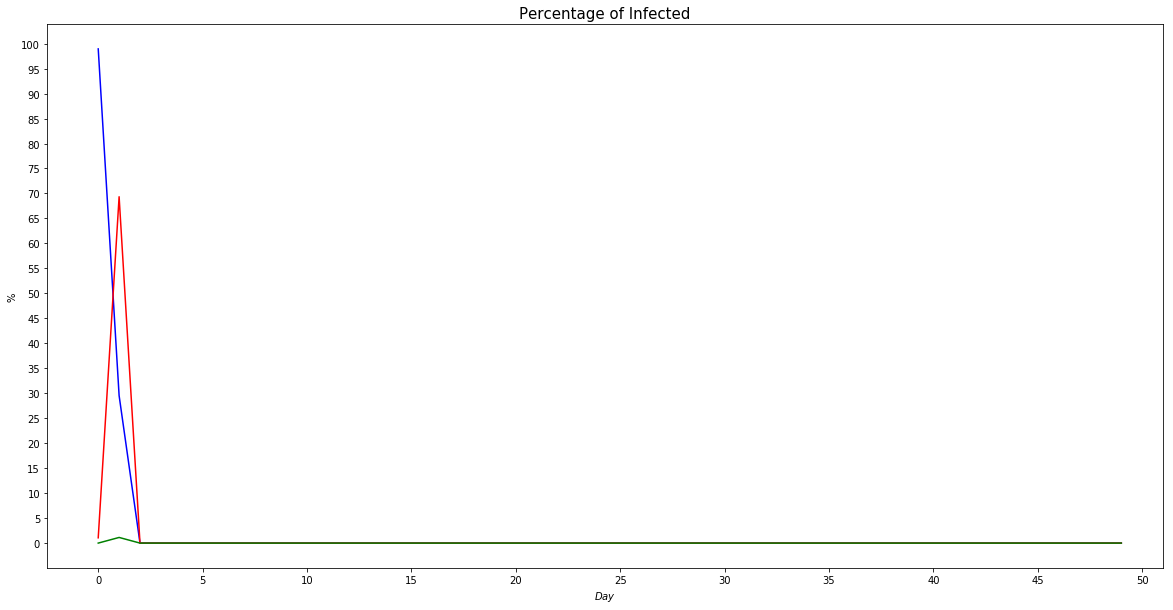

In [254]:
drawResultsMod(tps, n)

In [249]:
np.sum(tps[:,2*n:3*n], axis=1)

array([0.00000000e+000, 1.27914154e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 0.00000000e+000,
       0.00000000e+000, 0.00000000e+000, 0.00000000e+000, 1.19123699e-309,
       1.23471812e-309, 1.31214832e-309])